This example is from https://medium.com/luca-chuangs-bapm-notes/build-a-neural-network-in-python-multi-class-classification-e940f74bd899

In [2]:

# for reading data
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [3]:
# read in the data
df = pd.read_csv('satellites.csv',index_col='Index')

# shuffle the dataset! 
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
orbit_codes = pd.read_csv('orbit_codes.csv')
orbit_codes = pd.DataFrame(df['Orbit Type'].value_counts()).merge(orbit_codes,on='Orbit Type')
orbit_classes = {'GEO': ['S4D','S4E','S4G','S4H','S4I','S4J'],
                 'LEO': ['S41','S42','S43','S44','S45','S46'],
                 'MEO': ['S4A'],
                 'HEO': ['S4K','S4M'],
                 'Deep Space': ['S4C','S4V','S4W']}
orb_typ = {}
for key,value in orbit_classes.items():
    for code in value:
        orb_typ[code] = key
df['Orbit'] = df.loc[:,('Orbit Type')].map(orb_typ)
print(df['Orbit'].value_counts())
df_og = df.copy()
df = df_og.drop(columns='Orbit Type').copy()

Orbit
LEO           517
GEO           376
MEO            85
HEO            31
Deep Space     15
Name: count, dtype: int64


In [8]:
# split into X and Y
Y = df['Orbit']
X = df.drop(['Orbit'], axis=1)

print(X.shape)
print(Y.shape)

# convert to numpy arrays
X = np.array(X)

(1024, 6)
(1024,)


In [9]:
# show Y
Y.head()

0    MEO
1    LEO
2    LEO
3    LEO
4    LEO
Name: Orbit, dtype: object

In [10]:
# work with labels
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

print(encoded_Y)

print(dummy_y)


[4 3 3 ... 3 4 3]
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [65]:
# build a model
model = Sequential()
model.add(Dense(12, input_shape=(X.shape[1],), activation='relu')) # input shape is (features,)
model.add(Dense(8,activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

# compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', # this is different instead of binary_crossentropy (for regular classification)
              metrics=['sparse_categorical_accuracy'])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 12)                84        
                                                                 
 dense_26 (Dense)            (None, 8)                 104       
                                                                 
 dense_27 (Dense)            (None, 5)                 45        
                                                                 
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________


In [66]:
import keras
from keras.callbacks import EarlyStopping

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True) # important - otherwise you just return the last weigths...

# now we just update our model fit call
history = model.fit(X,
                    encoded_Y,
                    # dummy_y,
                    callbacks=[es],
                    epochs=10000, # you can set this to a big number!
                    batch_size=10,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=2)

Epoch 1/10000
82/82 - 1s - loss: 131.0123 - sparse_categorical_accuracy: 0.0806 - val_loss: 48.5651 - val_sparse_categorical_accuracy: 0.1707 - 763ms/epoch - 9ms/step
Epoch 2/10000
82/82 - 0s - loss: 18.9728 - sparse_categorical_accuracy: 0.3785 - val_loss: 4.1211 - val_sparse_categorical_accuracy: 0.5854 - 152ms/epoch - 2ms/step
Epoch 3/10000
82/82 - 0s - loss: 3.6234 - sparse_categorical_accuracy: 0.6630 - val_loss: 2.7469 - val_sparse_categorical_accuracy: 0.6976 - 164ms/epoch - 2ms/step
Epoch 4/10000
82/82 - 0s - loss: 2.5679 - sparse_categorical_accuracy: 0.7094 - val_loss: 2.1633 - val_sparse_categorical_accuracy: 0.7317 - 137ms/epoch - 2ms/step
Epoch 5/10000
82/82 - 0s - loss: 2.0297 - sparse_categorical_accuracy: 0.7363 - val_loss: 1.8523 - val_sparse_categorical_accuracy: 0.7268 - 147ms/epoch - 2ms/step
Epoch 6/10000
82/82 - 0s - loss: 1.6539 - sparse_categorical_accuracy: 0.7509 - val_loss: 1.5882 - val_sparse_categorical_accuracy: 0.7463 - 147ms/epoch - 2ms/step
Epoch 7/1000

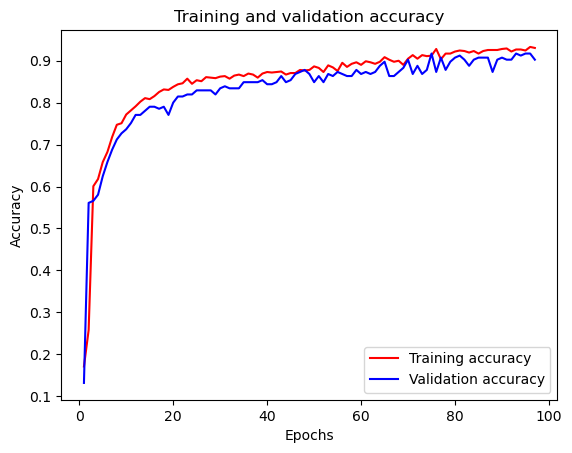

In [64]:
import matplotlib.pyplot as plt
history_dict = history.history

# learning curve
# accuracy
# acc = history_dict['accuracy']
acc = history_dict['sparse_categorical_accuracy']
# val_acc = history_dict['val_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [43]:
preds.argmax(axis=1)

array([2, 3, 3, ..., 3, 4, 3], dtype=int64)

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

preds = model.predict(X) # see how the model did!
print(preds[0]) # i'm spreading that prediction across three nodes and they sum to 1
print(np.sum(preds[0])) # sum it up! Should be 1
## [9.9999988e-01 1.3509347e-07 6.7064638e-16]
## 1.0

# Almost a perfect prediction
# actual is left, predicted is top
# names can be found by inspecting Y
matrix = confusion_matrix(dummy_y.argmax(axis=1), preds.argmax(axis=1))
matrix

# more detail on how well things were predicted
print(classification_report(dummy_y.argmax(axis=1), preds.argmax(axis=1)))


32/32 [==============================] - 0s 2ms/step
[0.15359288 0.1498636  0.20363222 0.07102808 0.4218832 ]
1.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.96      0.99      0.97       376
           2       0.24      0.13      0.17        31
           3       0.97      0.98      0.98       517
           4       0.70      0.84      0.76        85

    accuracy                           0.93      1024
   macro avg       0.57      0.59      0.58      1024
weighted avg       0.91      0.93      0.92      1024



C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
# build a model
model = Sequential()
model.add(Dense(12, input_shape=(X.shape[1],), activation='relu')) # input shape is (features,)
model.add(Dense(8,activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

# compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', # this is different instead of binary_crossentropy (for regular classification)
              metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 12)                84        
                                                                 
 dense_20 (Dense)            (None, 8)                 104       
                                                                 
 dense_21 (Dense)            (None, 5)                 45        
                                                                 
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________


In [60]:
import keras
from keras.callbacks import EarlyStopping

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True) # important - otherwise you just return the last weigths...

# now we just update our model fit call
history = model.fit(X,
                    # encoded_Y,
                    dummy_y,
                    callbacks=[es],
                    epochs=10000, # you can set this to a big number!
                    batch_size=10,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=2)

Epoch 1/10000
82/82 - 1s - loss: 31.7563 - accuracy: 0.1807 - val_loss: 13.2517 - val_accuracy: 0.2683 - 817ms/epoch - 10ms/step
Epoch 2/10000
82/82 - 0s - loss: 8.1792 - accuracy: 0.3834 - val_loss: 5.3984 - val_accuracy: 0.5415 - 157ms/epoch - 2ms/step
Epoch 3/10000
82/82 - 0s - loss: 4.6997 - accuracy: 0.5775 - val_loss: 3.9702 - val_accuracy: 0.6488 - 145ms/epoch - 2ms/step
Epoch 4/10000
82/82 - 0s - loss: 3.4677 - accuracy: 0.6557 - val_loss: 3.0396 - val_accuracy: 0.6537 - 158ms/epoch - 2ms/step
Epoch 5/10000
82/82 - 0s - loss: 2.6290 - accuracy: 0.6947 - val_loss: 2.4677 - val_accuracy: 0.6976 - 150ms/epoch - 2ms/step
Epoch 6/10000
82/82 - 0s - loss: 2.0900 - accuracy: 0.7387 - val_loss: 2.0979 - val_accuracy: 0.6780 - 149ms/epoch - 2ms/step
Epoch 7/10000
82/82 - 0s - loss: 1.6555 - accuracy: 0.7668 - val_loss: 1.8307 - val_accuracy: 0.7171 - 143ms/epoch - 2ms/step
Epoch 8/10000
82/82 - 0s - loss: 1.3091 - accuracy: 0.8046 - val_loss: 1.4736 - val_accuracy: 0.7610 - 158ms/epoch 

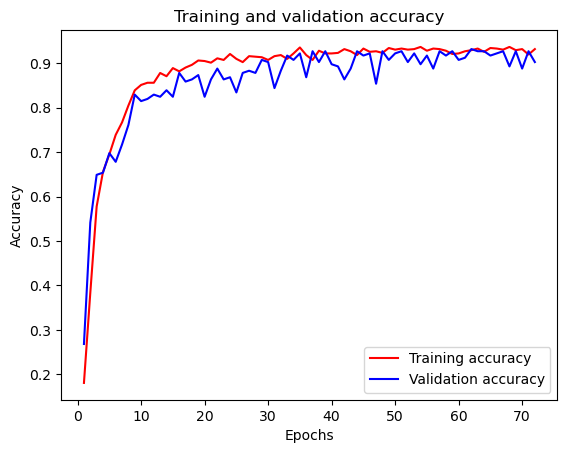

In [61]:
import matplotlib.pyplot as plt
history_dict = history.history

# learning curve
# accuracy
acc = history_dict['accuracy']
# acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_accuracy']
# val_acc = history_dict['val_sparse_categorical_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [58]:
preds = model.predict(X) # see how the model did!
print(preds[0]) # i'm spreading that prediction across three nodes and they sum to 1
print(np.sum(preds[0])) # sum it up! Should be 1

# actual is left, predicted is top
# names can be found by inspecting Y
matrix = confusion_matrix(dummy_y.argmax(axis=1), preds.argmax(axis=1))
matrix

# more detail on how well things were predicted
print(classification_report(dummy_y.argmax(axis=1), preds.argmax(axis=1)))


32/32 [==============================] - 0s 1ms/step
[1.2686861e-02 9.0037906e-01 2.1826515e-02 1.4247483e-06 6.5106221e-02]
1.0000001
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.95      0.99      0.97       376
           2       0.00      0.00      0.00        31
           3       0.98      1.00      0.99       517
           4       0.69      0.87      0.77        85

    accuracy                           0.94      1024
   macro avg       0.52      0.57      0.55      1024
weighted avg       0.90      0.94      0.92      1024



C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
